In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pylab as plt
import datetime
import cmocean
import numpy as np
import dateutil
import scipy.interpolate as scint

In [2]:
def plot_section(section):

    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 8}

    plt.rc('font', **font)
    
    cprops= {'dissic':(1900,2300,cmocean.cm.turbid,40,100,1e3),}
#          'talk':(1900,2240,cmocean.cm.turbid,34,100,1e3),
#          'no3':(1900,2240,cmocean.cm.turbid,34,100,1e3),
#          'po4':(1900,2240,cmocean.cm.turbid,34,100,1e3),
#          'cfc11':(1900,2240,cmocean.cm.turbid,34,100,1e3),
#          'sf6':(1900,2240,cmocean.cm.turbid,34,100,1e3),
#          'so':(1900,2240,cmocean.cm.turbid,34,100,1e3),
#          'thetao':(1900,2240,cmocean.cm.turbid,34,100,1e3),

    from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)
    
    if len(section.station) != section.shape[1]:
        section = section.T

    minvalue_conc,maxvalue_conc,cmap,nsteps,labelstep,cfactor = cprops[section.name]

    cstep = abs(minvalue_conc-maxvalue_conc)/nsteps

    cbarstep = abs(minvalue_conc-maxvalue_conc)/(nsteps/4);

    contour_levs = np.arange(minvalue_conc,maxvalue_conc+cstep,cstep)

    contour_labels = np.arange(minvalue_conc,maxvalue_conc+cstep,labelstep)

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig.dpi=300
    fig.set_figheight(4)
    fig.set_figwidth(2.5)
    ax1.set_title(f'{section.long_name}',fontsize=5)
    cax = ax1.contourf(section.station,section.lev,section,levels=contour_levs,extend='both',cmap=cmap)
    ax2.contourf(section.station,section.lev,section,levels=contour_levs,extend='both',cmap=cmap)

    cs1 = ax1.contour(section.station,section.lev,section,levels=contour_levs,extend='both',colors='0.6',linewidths=0.2)
    ax1.clabel(cs1,fontsize=4,fmt='%1.f')

    cs2 = ax2.contour(section.station,section.lev,section,levels=contour_levs,extend='both',colors='0.6',linewidths=0.2)
    ax2.clabel(cs2,fontsize=4,fmt='%1.f')

    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())

    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(0.5)
        ax2.spines[axis].set_linewidth(0.5)

    ax1.tick_params(which='both', width=0.5)
    ax2.tick_params(which='both', width=0.5)

    ax1.set_facecolor('k')
    ax2.set_facecolor('k')
    ax1.set_ylim(1000,0)
    ax2.set_ylim(6000,1000)

    cbar_ax = fig.add_axes([0.95, 0.2, 0.04, 0.6])
    cbar = fig.colorbar(cax, cax=cbar_ax,extend='both')
    cbar.ax.tick_params(labelsize=5)
    cbar.ax.tick_params(which='both', width=0.5)
    cbar.outline.set_linewidth(0.5)
    
    return fig,ax1,ax1

In [3]:
def get_expocode(cruise_id):
    return expc[expc.ID==cruise_id].EXPOCODE.values[0]

In [4]:
def regridder(model,obs,ovar_name):

    bgc_ovar_names = ['dissic','no3','po4','talk']

    # z distance is much less than distance between stations
    scale_factor = model.dx.mean().values*1e3

    ovar_obs = obs.iloc[0:,2].values.ravel()
    
    stations_obs = obs.station.values.ravel()
    depth_obs = obs.depth.values.ravel()


    stations_model = model.station.values.ravel()
    depth_model = model.lev.values.ravel()

    stations_model,depth_model = np.meshgrid(stations_model,depth_model)

    interpolated_obs = scint.griddata((stations_obs, depth_obs/scale_factor),ovar_obs,
                              (stations_model, depth_model/scale_factor),
                              method='linear')

    interpolated_obs = xr.DataArray(interpolated_obs,dims = model.dims, coords = model.coords,attrs=model[ovar_name].attrs)
    interpolated_obs = interpolated_obs.where(~np.isnan(model[ovar_name]))
    interpolated_obs = interpolated_obs.to_dataset(name=ovar_name)
    
    return interpolated_obs

In [5]:
def glodap_to_model(cruise_id,glodap,coords,ovar_name):
    
    expocode=expc[expc.ID==cruise_id].EXPOCODE.values[0]
    section_obs = glodap[glodap.cruise==cruise_id]
    station_obs = coords[coords.cruise==cruise_id]['station'] # get the station numbers for this particular cruise
    

    section_model = xr.open_mfdataset(f'../../../sections/{ovar_name}_{model}_r*_{expocode}.nc')
    section_obs = section_obs[section_obs.station.isin(station_obs)]
    section_model['station'] = station_obs.values # replace global station index with one for this cruise

    section_obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]] # grab ovar_name from the section
    section_obs[section_obs==-9999]= np.NaN # station_obs must have -9999 replaced with nans
    section_obs = section_obs.dropna()
    
    # If there are no obs of this variable, section_obs will be empty.
    # Here we make sure this cruise has observations of this variable before interpolation
    if len(section_obs) > 0:

        obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]].dropna()
        model_output = section_model

        interpolated_obs = regridder(model_output,obs,ovar_name)

        interpolated_obs.to_netcdf(f'../../../sections/{ovar_name}_{model}_OBSERVED_{expocode}.nc')

In [6]:
ovar_name_list = ['thetao','so','cfc11','sf6','dissic','no3','po4','talk']
bgc_ovar_names = ['dissic','no3','po4','talk']


model2glodap_ovar_name = {'thetao':'theta',
                          'so':'salinity',
                          'cfc11':'cfc11',
                          'sf6':'sf6',
                          'dissic':'tco2',
                          'no3':'no3',
                          'po4':'po4',
                          'talk':'talk',
                         }

cfactor = {'thetao':1,
           'so':1,
           'cfc11':1,
           'sf6':1,
           'dissic':1e3,
           'no3':1e3,
           'po4':1e3,
           'talk':1e4,
           }

In [7]:
glodap = pd.read_csv('../../qc/GLODAPv2.2019_Merged_Master_File.csv')
glodap[glodap==-9999]= np.NaN
glodap

,cruise,station,cast,year,month,day,hour,minute,latitude,longitude,...,toc,tocf,doc,docf,don,donf,tdn,tdnf,chla,chlaf
0,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
1,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
2,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
3,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
4,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
5,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
6,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
7,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
8,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0
9,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.567,7.2267,...,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0


In [8]:
coords = pd.read_csv('../../qc/GLODAPv2.2019_COORDS.csv')
coords

,Unnamed: 0,bearing,cruise,dx,latitude,longitude,month,station,year
0,0,0.000000,15.0,0.000000,-53.00800,0.03060,1.0,16.0,2005.0
1,1,178.251596,15.0,54.844928,-53.50100,0.00530,1.0,21.0,2005.0
2,2,179.993223,15.0,55.263879,-53.99800,0.00520,1.0,25.0,2005.0
3,3,-178.246834,15.0,57.181294,-54.51200,0.03230,1.0,26.0,2005.0
4,4,178.652229,15.0,54.500775,-55.00200,0.01220,2.0,27.0,2005.0
5,5,179.655321,15.0,55.487285,-55.50100,0.00690,2.0,28.0,2005.0
6,6,179.666518,15.0,7.561383,-55.56900,0.00620,2.0,29.0,2005.0
7,7,179.578260,15.0,48.148722,-56.00200,0.00050,2.0,30.0,2005.0
8,8,-179.865827,15.0,55.041642,-56.49700,0.00260,2.0,31.0,2005.0
9,9,-178.361315,15.0,51.727059,-56.96200,0.02700,2.0,33.0,2005.0


In [9]:
expc = pd.read_csv('../../qc/FILTERED_GLODAP_EXPOCODE.csv')
expc[expc['EXPOCODE']==expc['EXPOCODE'][0]]

,Unnamed: 0,ID,EXPOCODE,LINE
0,14,15,06AQ20050122,A12


In [10]:
model = 'CanESM5'
ovar_name = 'dissic'
expocode = '06AQ20050122'
cruise_id = 15

section_obs = glodap[glodap.cruise==cruise_id]
station_obs = coords[coords.cruise==cruise_id]['station']

section_model = xr.open_mfdataset(f'../../../sections/{ovar_name}_{model}_r*_{expocode}.nc')
section_obs = section_obs[section_obs.station.isin(station_obs)]
section_model['station'] = station_obs.values

section_obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]]
section_obs = section_obs.dropna()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [11]:
obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]].dropna()
model_output = section_model

interpolated_obs = regridder(model_output,obs,ovar_name)

In [12]:
new_attrs = model_output[ovar_name].attrs
model_output[ovar_name] = model_output[ovar_name]*1e3
model_output[ovar_name].attrs = new_attrs

(<Figure size 750x1200 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f555c6bb358>)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


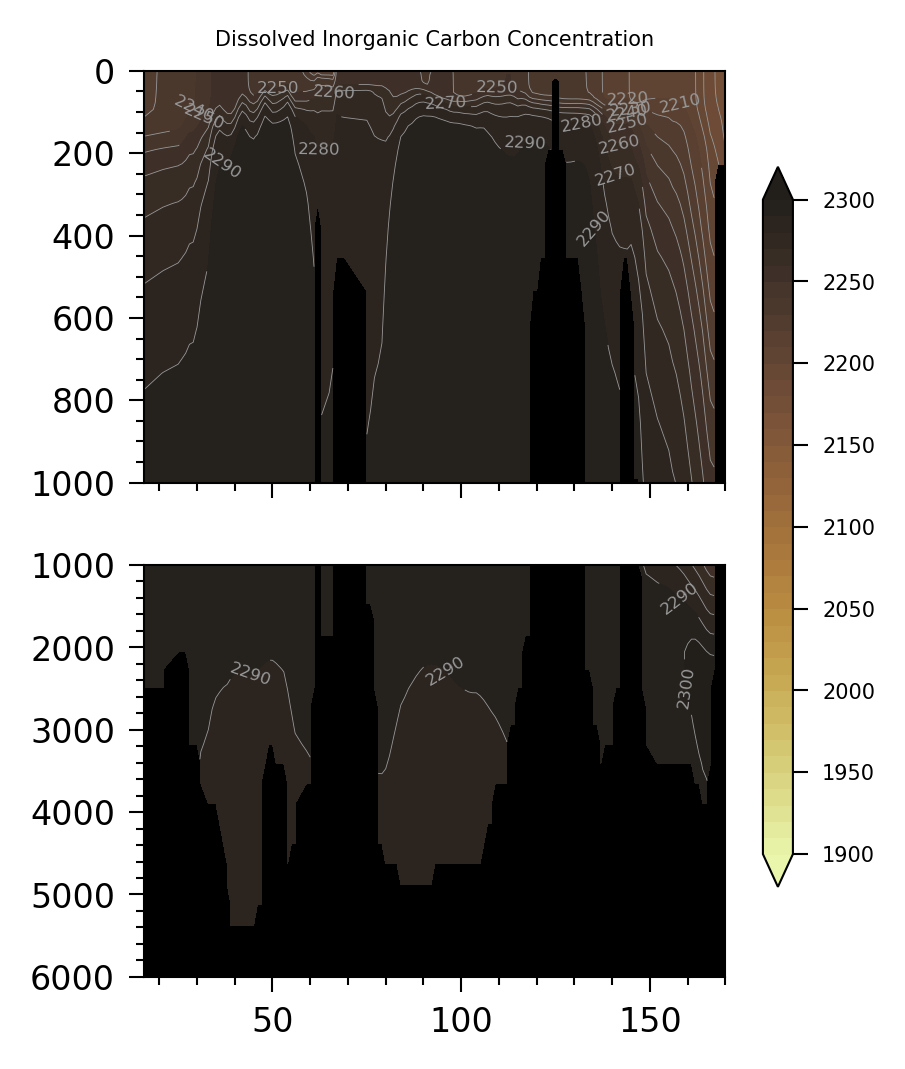

In [13]:
plot_section(model_output[ovar_name])

(<Figure size 750x1200 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f555c291b70>)

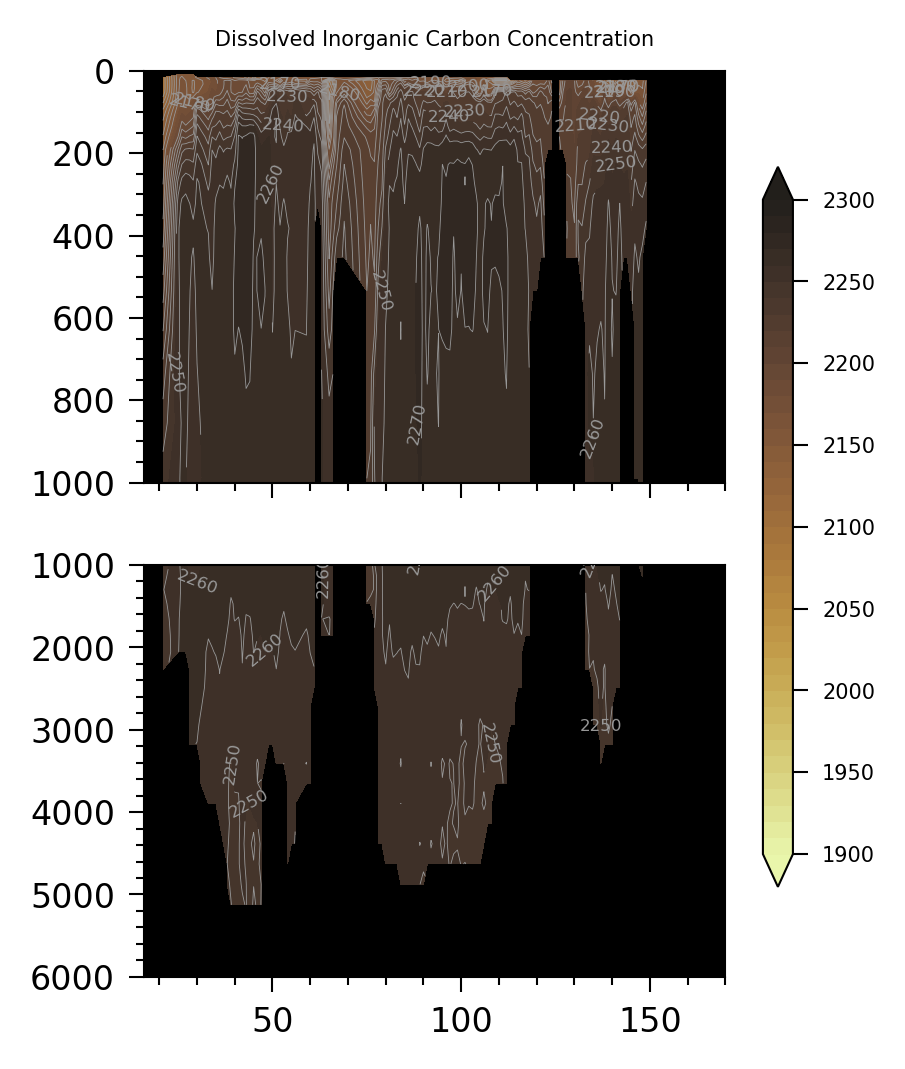

In [14]:
plot_section(interpolated_obs[ovar_name])

In [15]:
def glodap_to_model(cruise_id,glodap,coords,ovar_name):
    
    expocode=expc[expc.ID==cruise_id].EXPOCODE.values[0]
    section_obs = glodap[glodap.cruise==cruise_id]
    station_obs = coords[coords.cruise==cruise_id]['station'] # get the station numbers for this particular cruise
    

    section_model = xr.open_mfdataset(f'../../../sections/{ovar_name}_{model}_r*_{expocode}.nc')
    section_obs = section_obs[section_obs.station.isin(station_obs)]
    section_model['station'] = station_obs.values # replace global station index with one for this cruise

    section_obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]] # grab ovar_name from the section
    section_obs[section_obs==-9999]= np.NaN # station_obs must have -9999 replaced with nans
    section_obs = section_obs.dropna()
    
    # If there are no obs of this variable, section_obs will be empty.
    # Here we make sure this cruise has observations of this variable before interpolation
    if len(section_obs) > 0:

        obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]].dropna()
        model_output = section_model

        interpolated_obs = regridder(model_output,obs,ovar_name)

        interpolated_obs.to_netcdf(f'../../../sections/{ovar_name}_{model}_OBSERVED_{expocode}.nc')

In [16]:
%%capture
coords_cruise_mean = coords.groupby('cruise').mean()
coords_cruise_mean = coords_cruise_mean[coords_cruise_mean.year<2015]

for cruise_id in zip(coords_cruise_mean.index.values):
    glodap_to_model(cruise_id,glodap,coords,ovar_name)

QhullError: QH6019 qhull input error: can not scale last coordinate.  Input is cocircular
   or cospherical.   Use option 'Qz' to add a point at infinity.

While executing:  | qhull d Qz Qt Qc Qbb Q12
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 870952944  delaunay  Qz-infinity-point  Qtriangulate  Qcoplanar-keep
  Qbbound-last  Q12-no-wide-dup  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood


In [17]:
print(get_expocode(cruise_id))

49NZ20140709
